In [3]:
from google.colab import files
uploaded = files.upload()

Saving sellers.csv to sellers.csv
Saving products.csv to products.csv
Saving payments.csv to payments.csv
Saving orders.csv to orders.csv
Saving order_items.csv to order_items.csv
Saving geolocation.csv to geolocation.csv
Saving customers.csv to customers.csv


Daily span: 2016-09-04 → 2018-10-17
Total days: 774 | Total sales: 16008872.12


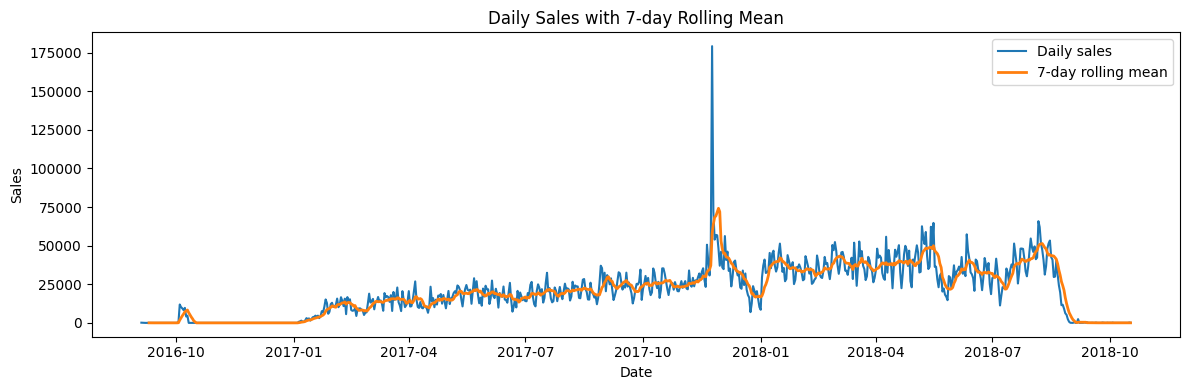

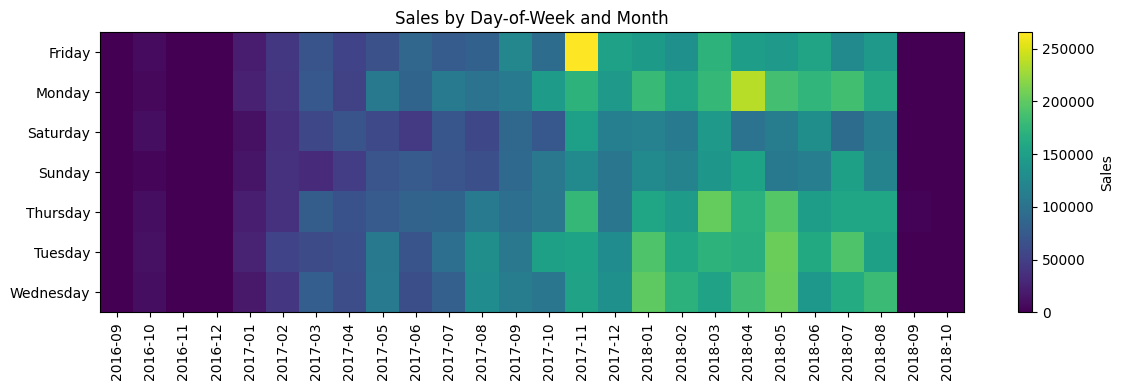


Basic Stats
 count       774.00
mean      20683.30
std       16805.27
min           0.00
25%        6636.25
50%       20479.54
75%       32423.66
max      179200.03
Name: sales, dtype: float64

Train: 2016-09-04 → 2018-08-04 | Test: 2018-08-05 → 2018-09-03

Model Comparison (lower is better):
                                       model        MAE       RMSE   sMAPE  \
0  Linear Regression (lags+rolls+dow/month)   6102.307   7264.895  56.693   
1               Gradient Boosting Regressor   6854.778   8158.623  58.065   
2                     Seasonal Naive (lag7)  13055.129  16033.412  71.653   
3                   Naive (lag1 last value)  19555.086  24440.274  75.567   

     WAPE  
0  21.863  
1  24.559  
2  46.773  
3  70.061  


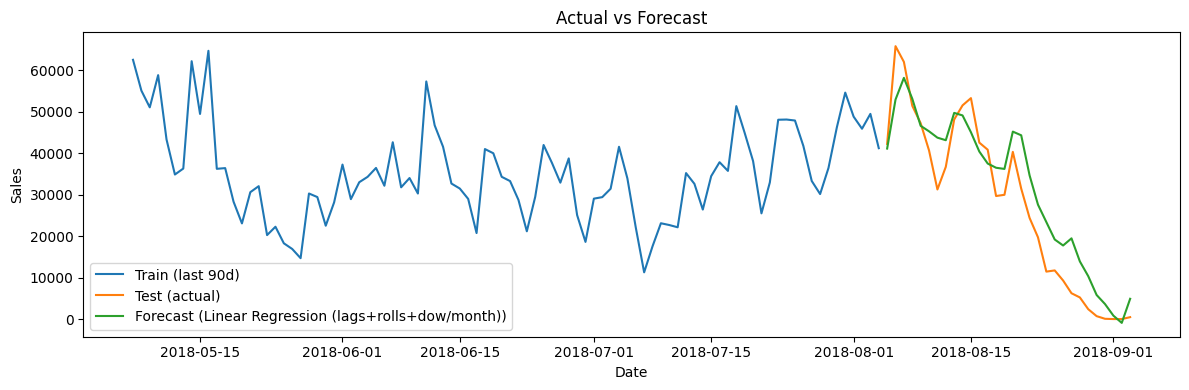


Top Feature Importances (GBR):
         feature  importance
5   roll_mean_7      0.6830
6    roll_std_7      0.1225
0         lag_1      0.0881
9           dow      0.0497
7  roll_mean_14      0.0159
8   roll_std_14      0.0152
4        lag_14      0.0096
3         lag_7      0.0057
1         lag_2      0.0042
2         lag_3      0.0041

Saved: forecast_model_comparison.csv, gbr_feature_importances.csv


In [6]:
# ============================================================
# Target E-commerce — Daily Sales Forecast (end-to-end, cleaned)
# ============================================================

# 0) Imports
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from datetime import timedelta

# 1) Load data (CSV files must be in /content or your working dir)
customers   = pd.read_csv("customers.csv")
sellers     = pd.read_csv("sellers.csv")
order_items = pd.read_csv("order_items.csv")
geoloc      = pd.read_csv("geolocation.csv")
payments    = pd.read_csv("payments.csv")
orders      = pd.read_csv("orders.csv")
products    = pd.read_csv("products.csv")

# 2) Build daily sales (sum of all payments per purchase day)
orders["order_purchase_timestamp"] = pd.to_datetime(orders["order_purchase_timestamp"], errors="coerce")
pay_agg = payments.groupby("order_id", as_index=False)["payment_value"].sum()
df = orders.merge(pay_agg, on="order_id", how="left")

daily_sales = (
    df.groupby(df["order_purchase_timestamp"].dt.date)["payment_value"]
      .sum()
      .reset_index()
      .rename(columns={"order_purchase_timestamp":"date","payment_value":"sales"})
)
daily_sales["date"] = pd.to_datetime(daily_sales["date"])
daily_sales = daily_sales.sort_values("date", ascending=True).reset_index(drop=True)

# Fill missing calendar days with 0 to keep a continuous series
full_dates = pd.DataFrame({"date": pd.date_range(daily_sales["date"].min(),
                                                 daily_sales["date"].max(), freq="D")})
daily_sales = full_dates.merge(daily_sales, on="date", how="left").fillna({"sales":0.0})

print("Daily span:", daily_sales["date"].min().date(), "→", daily_sales["date"].max().date())
print("Total days:", len(daily_sales), "| Total sales:", round(daily_sales["sales"].sum(),2))

# 3) Quick EDA plots (screenshots for your report)
plt.figure(figsize=(12,4))
plt.plot(daily_sales["date"], daily_sales["sales"], label="Daily sales")
plt.plot(daily_sales["date"], daily_sales["sales"].rolling(7).mean(), label="7-day rolling mean", linewidth=2)
plt.title("Daily Sales with 7-day Rolling Mean"); plt.xlabel("Date"); plt.ylabel("Sales"); plt.legend(); plt.tight_layout(); plt.show()

eda = daily_sales.copy()
eda["dow"] = eda["date"].dt.day_name()
eda["month"] = eda["date"].dt.to_period("M").astype(str)
pivot = eda.pivot_table(index="dow", columns="month", values="sales", aggfunc="sum").fillna(0)
plt.figure(figsize=(12,4))
plt.imshow(pivot.values, aspect="auto"); plt.yticks(range(len(pivot.index)), pivot.index)
plt.xticks(range(len(pivot.columns)), pivot.columns, rotation=90)
plt.title("Sales by Day-of-Week and Month"); plt.colorbar(label="Sales"); plt.tight_layout(); plt.show()

print("\nBasic Stats\n", daily_sales["sales"].describe().round(2))

# 4) Choose a SANE holdout window (avoid the zero tail)
ds2 = daily_sales.copy()
ds2["roll7"] = ds2["sales"].rolling(7).mean().fillna(0)

# Adaptive threshold: 5% of median or 1000, whichever is larger
thr = max(1000.0, 0.05 * daily_sales["sales"].median())
last_normal = ds2.loc[ds2["roll7"] > thr, "date"].max()

# If nothing passes the threshold, fall back to last 30 nonzero days
if pd.isna(last_normal):
    nonzero_dates = daily_sales.loc[daily_sales["sales"] > 0, "date"]
    last_normal = nonzero_dates.max()

HOLDOUT_DAYS = 30
test_end = last_normal
test_start = test_end - timedelta(days=HOLDOUT_DAYS-1)

train = daily_sales[daily_sales["date"] < test_start].copy()
test  = daily_sales[(daily_sales["date"] >= test_start) & (daily_sales["date"] <= test_end)].copy()

print(f"\nTrain: {train['date'].min().date()} → {train['date'].max().date()} "
      f"| Test: {test['date'].min().date()} → {test['date'].max().date()}")

# 5) Supervised features (lags, rolling stats, calendar)
def make_supervised(df_ts, lags=(1,2,3,7,14), rolls=(7,14)):
    X = df_ts.copy()
    for L in lags:
        X[f"lag_{L}"] = X["sales"].shift(L)
    for R in rolls:
        X[f"roll_mean_{R}"] = X["sales"].rolling(R).mean()
        X[f"roll_std_{R}"]  = X["sales"].rolling(R).std()
    X["dow"]   = X["date"].dt.weekday
    X["month"] = X["date"].dt.month
    return X.dropna().reset_index(drop=True)

lags, rolls = (1,2,3,7,14), (7,14)
sup = make_supervised(daily_sales, lags, rolls)

# Align supervised train/test by dates
sup_train = sup[sup["date"] < test["date"].min()].copy()
sup_test  = sup[(sup["date"] >= test["date"].min()) & (sup["date"] <= test["date"].max())].copy()

feat_cols = [c for c in sup_train.columns if c not in ["date","sales"]]
X_train, y_train = sup_train[feat_cols], sup_train["sales"]
X_test,  y_test  = sup_test[feat_cols],  sup_test["sales"]

# 6) Metrics (sMAPE & WAPE handle zeros better than MAPE)
def smape(y_true, y_pred):
    y_true = np.asarray(y_true); y_pred = np.asarray(y_pred)
    return 100 * np.mean(2 * np.abs(y_pred - y_true) /
                         (np.abs(y_true) + np.abs(y_pred) + 1e-9))

def wape(y_true, y_pred):
    y_true = np.asarray(y_true); y_pred = np.asarray(y_pred)
    return 100 * np.sum(np.abs(y_true - y_pred)) / (np.sum(np.abs(y_true)) + 1e-9)

metrics = []
def add_metrics(name, y_true, y_pred):
    metrics.append({
        "model": name,
        "MAE":  mean_absolute_error(y_true, y_pred),
        "RMSE": float(np.sqrt(mean_squared_error(y_true, y_pred))),
        "sMAPE": smape(y_true, y_pred),
        "WAPE":  wape(y_true, y_pred)
    })

# 7) Baselines on the SAME supervised test window
last_train_val = y_train.iloc[-1]
naive_pred = np.repeat(last_train_val, len(y_test))

# Seasonal naive (weekly) = yesterday vs last week → use our lag_7 feature directly
seasonal_naive_pred = sup_test["lag_7"].values  # already aligned, no NaNs in sup

add_metrics("Naive (lag1 last value)", y_test.values, naive_pred)
add_metrics("Seasonal Naive (lag7)",   y_test.values, seasonal_naive_pred)

# 8) ML models
lin = LinearRegression().fit(X_train, y_train)
lin_pred = lin.predict(X_test)
add_metrics("Linear Regression (lags+rolls+dow/month)", y_test.values, lin_pred)

gbr = GradientBoostingRegressor(random_state=42).fit(X_train, y_train)
gbr_pred = gbr.predict(X_test)
add_metrics("Gradient Boosting Regressor", y_test.values, gbr_pred)

# 9) Compare models
results = pd.DataFrame(metrics).sort_values("MAE").reset_index(drop=True)
print("\nModel Comparison (lower is better):\n", results.round(3))

# 10) Plot Actual vs Best Forecast
best_name = results.iloc[0]["model"]
pred_map = {
    "Naive (lag1 last value)": naive_pred,
    "Seasonal Naive (lag7)": seasonal_naive_pred,
    "Linear Regression (lags+rolls+dow/month)": lin_pred,
    "Gradient Boosting Regressor": gbr_pred
}
best_pred = pred_map.get(best_name, gbr_pred)

plt.figure(figsize=(12,4))
plt.plot(train["date"].iloc[-90:], train["sales"].iloc[-90:], label="Train (last 90d)")
plt.plot(test["date"], test["sales"], label="Test (actual)")
plt.plot(sup_test["date"], best_pred, label=f"Forecast ({best_name})")
plt.title("Actual vs Forecast"); plt.xlabel("Date"); plt.ylabel("Sales"); plt.legend(); plt.tight_layout(); plt.show()

# 11) Feature importance (GBR) + exportables
imp = pd.DataFrame({"feature": feat_cols, "importance": gbr.feature_importances_}) \
        .sort_values("importance", ascending=False)
print("\nTop Feature Importances (GBR):\n", imp.head(10).round(4))

# Save CSVs for your report
results.round(3).to_csv("forecast_model_comparison.csv", index=False)
imp.round(4).to_csv("gbr_feature_importances.csv", index=False)
print("\nSaved: forecast_model_comparison.csv, gbr_feature_importances.csv")


In [10]:
# === One-cell: build & download Ops Planning Pack Excel ===
import sys, subprocess, importlib.util
import pandas as pd, numpy as np

# install writer if missing
if importlib.util.find_spec("xlsxwriter") is None and importlib.util.find_spec("openpyxl") is None:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "xlsxwriter"])

# ---------- assumptions (edit as needed) ----------
AOV = 100.0                   # avg order value (currency)
MIN_PER_ORDER = 6.0           # pick+pack minutes per order
SHIFT_HOURS = 8.0             # hours per worker shift
LEAD_TIME_DAYS = 5            # replenishment lead time (days)
Z_SERVICE = 1.28              # ~90% service level
LINES_PER_ORDER = 1.2         # avg lines/items per order
AVG_WEIGHT_PER_ORDER_KG = 1.5 # avg shipment weight (kg)
TRUCK_CAPACITY_KG = 1000.0    # capacity per truck (kg)

# ---------- load data from memory or CSVs ----------
if 'ops_staffing' in globals() and 'ops_inventory' in globals():
    staff = ops_staffing.copy()
    inv   = ops_inventory.copy()
else:
    staff = pd.read_csv("forecast_to_staffing.csv")
    inv   = pd.read_csv("forecast_to_inventory.csv")

# ensure datetime
for _df in (staff, inv):
    if 'date' in _df.columns:
        _df['date'] = pd.to_datetime(_df['date'])

# ---------- tidy / rounding ----------
staff_out = staff.copy()
staff_out['orders']      = staff_out['orders'].round(0).astype(int)
staff_out['labor_hours'] = staff_out['labor_hours'].round(1)
staff_out['headcount']   = staff_out['headcount'].astype(int)

inv_out = inv.copy()
for c in ['DLT_orders','safety_stock_orders','ROP_orders']:
    inv_out[c] = inv_out[c].round(0).astype(int)

# logistics derived from orders
logi = staff_out[['date','orders']].copy()
logi['parcels']        = np.ceil(logi['orders'] * LINES_PER_ORDER).astype(int)
logi['trucks_needed']  = np.ceil((logi['orders'] * AVG_WEIGHT_PER_ORDER_KG) / TRUCK_CAPACITY_KG).astype(int)

# assumptions sheet
assump = pd.DataFrame({
    'parameter': [
        'AOV','MIN_PER_ORDER','SHIFT_HOURS','LEAD_TIME_DAYS','Z_SERVICE',
        'LINES_PER_ORDER','AVG_WEIGHT_PER_ORDER_KG','TRUCK_CAPACITY_KG'
    ],
    'value': [AOV, MIN_PER_ORDER, SHIFT_HOURS, LEAD_TIME_DAYS, Z_SERVICE,
              LINES_PER_ORDER, AVG_WEIGHT_PER_ORDER_KG, TRUCK_CAPACITY_KG],
    'notes': [
        'currency/order','minutes per order','hours/shift','days','z-score (service level)',
        'avg lines per order','avg shipment weight','kg per truck'
    ]
})

# ---------- write Excel ----------
engine = "xlsxwriter" if importlib.util.find_spec("xlsxwriter") else "openpyxl"
out_path = "ops_planning_pack.xlsx"
with pd.ExcelWriter(out_path, engine=engine) as xw:
    assump.to_excel(xw, sheet_name="Assumptions", index=False)
    inv_out.to_excel(xw, sheet_name="Inventory_ROP", index=False)
    staff_out.to_excel(xw, sheet_name="Staffing", index=False)
    logi.to_excel(xw, sheet_name="Logistics", index=False)

print(f"Saved: {out_path} (engine={engine})")

# ---------- download in Colab ----------
try:
    from google.colab import files
    files.download(out_path)
except Exception as e:
    print("If not in Colab, fetch the file from your working directory:", out_path)


Saved: ops_planning_pack.xlsx (engine=openpyxl)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>